In [16]:
# Copyright (C) 2023-2024 Jingtao Lai <lai@gfz-potsdam.de>
# Scripts for manuscript submitted to GRL titled "Climate-driven topographic asymmetry enhanced by glaciers: Implication for drainage reorganization in glacial landscapes"

import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.special as ss
from scipy.optimize import root_scalar

savepath = './'
if not os.path.isdir(savepath):
    os.mkdir(savepath)

In [2]:
''' Written by Eric Deal, 10.2020. Script should be run using python 3.'''
''' Modified by Jingtao Lai, Oct, 2023. Modification: use zf(0) + xo*tan(thresold_slope) < ELA as threshold for purely fluvial, turnoff xt > L case.'''

class glacial_profile_model(object):
    '''Script to accompany the paper 'The Sliding Ice Incision Model: A new approach to understanding glacial landscape evolution' be Eric Deal
    and Guenther Prasicek. The parameter names here should match those given in the paper.'''

    def __init__(self,
        # system size and boundary conditions
        U=1e-3, # uplift rate in m/yr
        L=50e3, # profile length in m
        # climatic forcing, P and beta must be specified for the erodability coefficients, either ELA is specified, or To is specified. 
        # If To is specified then ELA is determined by the combination of P, beta and To, if ELA is specified, then To is adjusted to give the
        # chosen ELA with the given P and beta.
        delta=2e-3, # solid preciipitation lapse rate in 1/yr
        P=1, # mean rainfall rate in m/yr
        To=None, # Elevation where 100% of precipitation is converted to glacial ice in m
        ELA=None, # Equilibrium Line Altitude (elevation, h, where P - delta*(To-h) = 0) in m
        # fluvial parameters
        K=1e-6, # fluvial erodibility coefficient (units depend on n and m)
        fluvial_slope_exp=1, # fluvial slope exponent, n
        # glacial parameters
        ce=1e-4, # glacial erodibility coefficient (units depend on ell)
        ice_sliding_exp=1, # ice sliding exponent, ell
        # plot profile or not
        plot=True):

        if plot is True: plt.figure(1, figsize=(10,6))

        ### set variables and parameters (all units in meters and years unless otherwise specified)
        # number of points to calculate solution on between 0 and L
        self.N = 1000

        # physical constraints
        self.U, self.L, self.P, self.delta = (U, L, P, delta)
        # if neither ELA or To is user defined
        if ELA is None and To is None: self.ELA, self.To = 1000, 1000 + self.P/self.delta
        # if To is user defined, but not ELA
        elif ELA is None and To is not None: self.ELA, self.To = To - self.P/self.delta, To
        # if ELA is user defined, then To is ignored, whether it was user defined or not.
        else: self.ELA, self.To = ELA, ELA + self.P/self.delta
        
        # fluvial exponents (the model requires that h*m/n=1)
        self.h_exp = 2 # fluvial hack's exponent
        self.omega_f = 1/2 # fluvial channel width exponent (just for plotting, value does not influence model)
        self.n = fluvial_slope_exp # slope exponent in SPIM
        self.m = self.n/2 # flux exponent in SPIM

        # fluvial constants
        self.xo = 500 # critical catchment area where hillslopes take over, max elevation is assumed to be proportional to fluvial elevation at xo
        self.kc = 2 # fluvial Hack's coefficient
        self.kw = 1 # fluvial channel width coefficient (just for plotting, value does not influence model)
        self.K = K # fluvial erosion coefficient
        self.ks = (self.U / ((self.kc * self.P)**self.m * self.K))**(1/self.n) # fluvial steepness index
        self.slope_threshold = 30 # critical hillsope angle

        # fluvial profile solution
        self.zf = lambda x: self.ks*np.log(self.L/x)
        self.Wf = lambda x: self.kw * x**self.omega_f # fluvial channel width (m)
        self.qf = lambda x: (self.P * self.kc * x**self.h_exp)**(1-self.omega_f) / self.kw # fluvial water flux density (m^2/yr)

        # glacial exponents
        self.eta = 2 # glacial Hack’s exponent
        self.phi = .5 # network branching parameter
        self.omega_g = 1/4 # glacial channel width exponent
        self.ell = ice_sliding_exp # glacial sliding erosion exponent
        self.psi = 3. # Glen’s flow law exponent
        self.gamma = 2/3 # ice flux approximation exponent
        self.kappa = self.psi / (1 + self.gamma*(self.psi - 1))
        self.lamb = self.gamma*(self.psi - 1) / (1 + self.gamma*(self.psi - 1))
        self.nu = self.ell * self.kappa # slope exponent in SIIM
        self.mu = self.ell * self.lamb * (1 - self.omega_g) # flux exponent in SIIM
        self.c1 = 1 - self.eta * self.mu / self.nu # ice accumulation exponent
        self.c2 = 1 - self.mu / self.nu # ice loss exponent
        self.r = (self.nu - self.eta * self.mu) / (self.nu + self.mu)
        # ice flow constants
        self.ro, self.g, self.cd, self.cb = (910.0, 9.81, 2.39e-24, 1.7e-19)
        self.fs, self.fd = (self.ro*self.g)**self.psi * self.cb * 31556926.0, (self.ro*self.g)**self.psi * self.cd * 31556926.0
        # glacial constants
        self.D = (1 - self.phi) * self.eta # divergence operator
        self.sigma = self.D / (1 + self.D) # ratio of relief above ELA to glacial relief
        self.cc = 2 # glacial hack's coefficient
        self.ca = 1/2 # ice flux approximation coefficient
        self.cw = 50 # glacial channel width coefficient
        self.ce = ce # ice sliding erosion coefficient
        self.cp = self.ca * (self.cb/self.cd)**((1-self.gamma)/(self.psi-1))
        self.ct = (self.cp * self.fs**(1/(self.psi-1)))**(self.lamb/self.gamma)
        self.C = self.ce*(self.ct/self.cw**self.lamb)**self.ell
        self.cs = (self.U * ss.beta(self.c1, self.c2)**self.nu / (self.C * (self.sigma*self.delta*self.cc)**self.mu)) ** (1 / (self.mu + self.nu))
        self.ck = (self.ks / self.cs) / (self.r * (self.sigma - 1))

        '''
        # find threshold xt that makes h(xo) = ELA
        def find_ho(input_x):
            return ss.betainc(self.c1, self.c2, self.xo/input_x) - self.sigma
        
        sol = root_scalar(find_ho, bracket=[self.xo, 5e3])
        xt_threshold = sol.root
        #print(xt_threshold)
    
        self.xt = (self.ck * np.real(ss.lambertw((self.L * np.exp(-self.ELA / self.ks))**self.r / self.ck)))**(1/self.r) # glacial terminus location along the profile
        '''
        # Pure fluvial profile
        if self.zf(self.xo) + np.tan(self.slope_threshold/180*np.pi)*self.xo < self.ELA:
            self.xf = np.linspace(self.xo, self.L, self.N) # x_axis for plotting fluvial profile
            self.Hmax = 0 # maximum ice thickness
            self.xt = 0 # location of glacial terminus
            self.ho = self.zf(self.xo) # maximum profile elevation

            if plot == True:
                plt.plot(self.xf/1000, self.zf(self.xf), 'k--', lw=1, label='Fluvial profile')
        else:
            # mixed glacial-fluvial
            self.xt = (self.ck * np.real(ss.lambertw((self.L * np.exp(-self.ELA / self.ks))**self.r / self.ck)))**(1/self.r) # glacial terminus location along the profile
            
            # glacial profile solution
            self.h = lambda x: self.ELA + self.cs * self.xt**self.r * (self.sigma - ss.betainc(self.c1, self.c2, x/self.xt)) # Ice surface elevation as a function of x
            #self.ho = self.ELA + self.cs * self.sigma * self.xt**self.r # maximum elevation
            self.ho = self.h(self.xo)
            self.Sgmean = (self.ho - self.zf(self.xt)) / self.xt # mean slope over glacier
            self.I = lambda x: self.sigma * self.delta * self.Sgmean * (self.xt - x) # Effective ice accumulation rate (m/yr)
            self.qg = lambda x: (self.I(x) * self.cc * x**self.eta)**(1-self.omega_g) / self.cw # Ice flux density (m^2/yr)
            self.H = lambda x: self.cp * (self.ce / self.U)**(self.gamma/self.ell) * self.qg(x) ** self.gamma # Ice thickness at steady state (m)
            self.Wg = lambda x: self.cw * x**self.omega_g # glacial channel width (m)
            self.zg = lambda x: self.h(x) - self.H(x) # subglacial bedrock elevation (m)
            if self.xt > self.xo:
                self.xg = np.linspace(self.xo, self.xt, self.N) # glacial profile x-axis (m)
                self.xf = np.linspace(self.xt, self.L, self.N) # fluvial profile x-axis (m)
            else:
                self.xg = np.linspace(1, self.xt, self.N)
                self.xf = np.linspace(self.xo, self.L, self.N)
            self.Hmax = np.max(self.H(self.xg)) # maximum ice thickness

            if plot == True:
                plt.plot(self.xf/1000, self.zf(self.xf), '-', c='gray', lw=1, label='Fluvial profile')
                if self.xt > self.xo:
                    plt.plot(self.xg/1000, self.zf(self.xg), ':', c='gray', lw=1, label='Fluvial profile cont.')
                    plt.plot(self.xg/1000, self.zg(self.xg), c='k', lw=1, label='Glacial profile')
                    plt.plot(self.xg/1000, self.h(self.xg), c='c', lw=1, label='Ice surface')
                    plt.fill_between(self.xg/1000, self.zg(self.xg), self.h(self.xg), alpha=.3, color='c')

        if plot is True:
            plt.plot((0, self.L/1e3), (self.ELA, self.ELA), 'r:', lw=0.5, label='ELA')
            plt.xlabel('Along profle distance (km)')
            plt.ylabel('Elevation above baselevel')
            plt.xlim(0,self.L/1e3)
            plt.ylim(0,self.ho+100)
            plt.legend(ncol=2)


## Figure 1

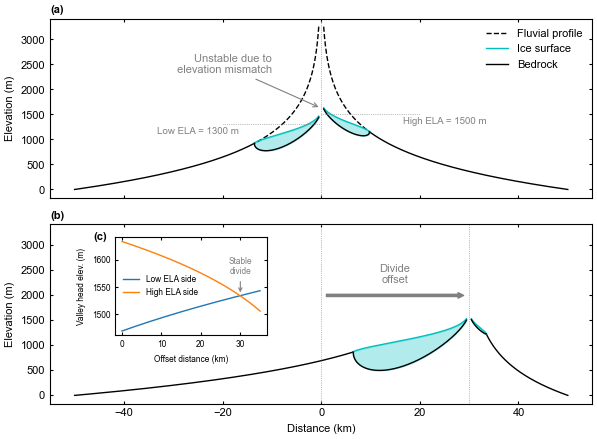

In [3]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15)

length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta, plot=False)
initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

ela = 1500
ela_diff = 200

gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela, P=P, delta=delta, plot=False)
gp_low = glacial_profile_model(U=uplift_rate, L=length, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

ax = axarr[0]

for k, gp in enumerate([gp_high, gp_low]):
    if k == 0:
        x_sign = 1
    else:
        x_sign = -1
    ax.plot(gp.xf*x_sign/1e3, gp.zf(gp.xf), '-', c='k', lw=1)
    if gp.xt > gp.xo:
        ax.plot(gp.xg*x_sign/1e3, gp.zf(gp.xg), '--', c='k', lw=1, label='Fluvial profile')
        ax.fill_between(gp.xg*x_sign/1e3, gp.zg(gp.xg), gp.h(gp.xg), alpha=.3, color='c')
        ax.plot(gp.xg*x_sign/1e3, gp.h(gp.xg), c='c', lw=1, label='Ice surface')
        ax.plot(gp.xg*x_sign/1e3, gp.zg(gp.xg), c='k', lw=1, label='Bedrock')

    if k == 0:
        ax.legend(loc='upper right', fontsize=8)

ax.axvline(0, linestyle=':', color='0.5', linewidth=0.5)

ax.hlines(ela, 0, 20, linestyle=':', color='0.5', linewidth=0.5)
ax.hlines(ela - ela_diff, -20, 0, linestyle=':', color='0.5', linewidth=0.5)

ax.text(25, ela-50, 'High ELA = {} m'.format(ela), fontsize=7, color='0.5',
        horizontalalignment='center', verticalalignment='top')
ax.text(-25, ela-ela_diff-50, 'Low ELA = {} m'.format(ela-ela_diff), fontsize=7, color='0.5',
        horizontalalignment='center', verticalalignment='top')

ax.annotate('Unstable due to\n elevation mismatch', xy=(0, 1625), xytext=(-10, 2500), color='grey', horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(color='grey', arrowstyle='->', linewidth=0.8))

#ax.legend()
ax.set_ylabel('Elevation (m)')

ax.text(0, 1.02, '(a)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

########################################
length_threshold = 1e3
def find_valley_head_difference(x, ela_high, ela_low):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low

sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff), method='brentq')
migration_distance = sol.root

gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, ELA=ela, P=P, delta=delta, plot=False)
gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

ax = axarr[1]

for k, gp in enumerate([gp_high, gp_low]):
    if k == 0:
        x_sign = 1
    else:
        x_sign = -1
    ax.plot((gp.xf*x_sign+migration_distance)/1e3, gp.zf(gp.xf), '-', c='k', lw=1)
    if gp.xt > gp.xo:
        ax.fill_between((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg), gp.h(gp.xg), alpha=.3, color='c')
        ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.h(gp.xg), c='c', lw=1, label='Ice surface')
        ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg), c='k', lw=1, label='Bedrock')

ax.axvline(0, linestyle=':', color='0.5', linewidth=0.5)
ax.axvline(migration_distance/1e3, linestyle=':', color='0.5', linewidth=0.5)

ax.annotate('', xy=(migration_distance/1e3-0.5, 2000), xytext=(0.5, 2000), color='grey', horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(color='grey', arrowstyle='simple'))

ax.text(migration_distance/1e3/2, 2200, 'Divide\noffset', fontsize=8, color='0.5',
        horizontalalignment='center', verticalalignment='bottom')

'''
ax.hlines(ela, migration_distance/1e3, migration_distance/1e3+20, linestyle='--', color='0.5', linewidth=0.5)
ax.hlines(ela - ela_diff, migration_distance/1e3-20, migration_distance/1e3, linestyle='--', color='0.5', linewidth=0.5)

ax.text(migration_distance/1e3+20, ela+50, 'High ELA = {} m'.format(ela), fontsize=8, color='0.5',
        horizontalalignment='center', verticalalignment='bottom')
ax.text(migration_distance/1e3-20, ela-ela_diff+50, 'Low ELA = {} m'.format(ela-ela_diff), fontsize=8, color='0.5',
        horizontalalignment='center', verticalalignment='bottom')
'''
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation (m)')

ax.text(0, 1.02, '(b)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

########################################
migration_distance_list = np.linspace(0, 35e3, 1001)
peak_high_list = []
peak_low_list = []

for migration_distance in migration_distance_list:

    gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, ELA=ela, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    '''
    try:
        peak_high = gp_high.zg(gp_high.xo)
    except AttributeError:
        peak_high = gp_high.zf(gp_high.xo)
    try:
        peak_low = gp_low.zg(gp_low.xo)
    except AttributeError:
        peak_low = gp_low.zf(gp_low.xo)
    '''

    peak_high_list.append(peak_high)
    peak_low_list.append(peak_low)

migration_distance_list = np.array(migration_distance_list)
peak_high_list = np.array(peak_high_list)
peak_low_list = np.array(peak_low_list)

ax = ax.inset_axes([0.12, 0.38, 0.28, 0.55])

ax.plot(migration_distance_list/1e3, peak_low_list, c='C0', label='Low ELA side', linewidth=1)
ax.plot(migration_distance_list/1e3, peak_high_list, c='C1', label='High ELA side', linewidth=1)


#ax.plot(migration_distance_list, h_xo, c='k')

ax.text(-0.05, 1.05, '(c)', fontweight='bold', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

ax.annotate('Stable\ndivide', xy=(30, 1535), xytext=(30, 1570), color='grey', horizontalalignment='center', verticalalignment='bottom', fontsize=6,
            arrowprops=dict(color='grey', arrowstyle='->', linewidth=0.8))

#ax.set_ylim([1570, 1695])

ax.tick_params(axis='both', labelsize=6)
ax.set_xlabel('Offset distance (km)', fontsize=6)
ax.set_ylabel('Valley head elev. (m)', fontsize=6)



ax.legend(loc='best', fontsize=6)

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_example_migration.pdf'), dpi=600)

### Figure S1

In [14]:
from scipy.optimize import root_scalar

length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

length_threshold = 1e3

def find_valley_head_difference(x, ela_high, ela_low):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low

#ela_low_list = np.linspace(peak_elev-500, peak_elev-500, 1)
#ela_diff_list = np.linspace(0, 300, 6)

migration_distance_dict = {}
peak_diff_dict = {}
peak_elev_dict = {}
two_side_glaciation_dict = {}

gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta, plot=False)
initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

plotting = False

for ela in np.linspace(0.4, 0.8, 101)*initial_peak_elev:
    for ela_diff in np.linspace(0, 800, 101):
        '''
        no_ice_threshold = length - np.exp(ela/gp_dummy.ks)*gp_dummy.xo
        if np.sign(find_valley_head_difference(0, ela, ela - ela_diff)) != np.sign(find_valley_head_difference(no_ice_threshold-1e-6, ela, ela - ela_diff)):
            sol = root_scalar(find_valley_head_difference, bracket=[0, no_ice_threshold-1e-6], args=(ela, ela - ela_diff))
            migration_distance = sol.root
        else:
            sol = root_scalar(find_valley_head_difference, bracket=[no_ice_threshold, length-length_threshold], args=(ela, ela - ela_diff))
            #sol = root_scalar(find_valley_head_difference, x0=no_ice_threshold-1e3, x1=no_ice_threshold+10e3, args=(ela, ela - ela_diff))
            migration_distance = sol.root
        '''
        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff), method='brentq')
        migration_distance = sol.root
        #print(ela, ela - ela_diff, migration_distance)

        gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, ELA=ela, P=P, delta=delta, plot=False)
        gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

        migration_distance_dict['high_ela_{}_low_ela_{}'.format(ela, ela - ela_diff)] = migration_distance
        peak_diff_dict['high_ela_{}_low_ela_{}'.format(ela, ela-ela_diff)] = find_valley_head_difference(0, ela, ela - ela_diff)
        peak_elev_dict['high_ela_{}_low_ela_{}'.format(ela, ela-ela_diff)] = gp_low.zg(gp_low.xo)
        
        if gp_high.xt > gp_high.xo:
            two_side_glaciation_dict['high_ela_{}_low_ela_{}'.format(ela, ela-ela_diff)] = True
        else:
            two_side_glaciation_dict['high_ela_{}_low_ela_{}'.format(ela, ela-ela_diff)] = False

        if plotting:
            plt.plot(gp_dummy.xf, gp_dummy.zf(gp_dummy.xf), '-.', c='gray', lw=1, label='Initial fluvial profile')
            plt.plot((0-gp_dummy.xf),gp_dummy.zf(gp_dummy.xf), '-.', c='gray', lw=1, label='Initial fluvial profile')

            try:
                plt.plot(gp_high.xf+migration_distance, gp_high.zf(gp_high.xf), '-', c='gray', lw=1, label='Fluvial profile')
            except AttributeError:
                pass
            try:
                plt.plot(gp_high.xg+migration_distance, gp_high.zg(gp_high.xg), c='k', lw=1, label='Glacial profile')
            except AttributeError:
                pass

            try:
                plt.plot((0-gp_low.xf+migration_distance), gp_low.zf(gp_low.xf), '-', c='gray', lw=1, label='Fluvial profile')
            except AttributeError:
                pass
            try:
                plt.plot((0-gp_low.xg+migration_distance), gp_low.zg(gp_low.xg), c='k', lw=1, label='Glacial profile')
            except AttributeError:
                pass

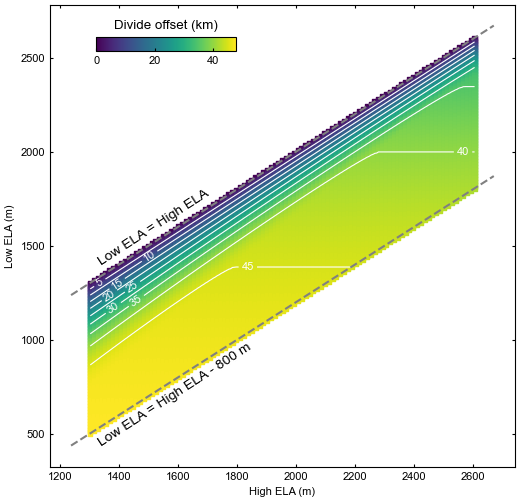

In [17]:
plt.close('all')
plt.style.use("myscience")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ela_high_list = []
ela_low_list = []
migration_distance_list = []
peak_diff_list = []
peak_elev_list = []
two_side_glaciation_list = []
for key in migration_distance_dict.keys():
    ela_high, ela_low = re.findall(r'[-+]?(?:\d*\.*\d+)', key)
    ela_high_list.append(float(ela_high))
    ela_low_list.append(float(ela_low))

    migration_distance_list.append(migration_distance_dict[key])
    peak_diff_list.append(peak_diff_dict[key])
    peak_elev_list.append(peak_elev_dict[key])
    two_side_glaciation_list.append(two_side_glaciation_dict[key])

c_list = np.array(migration_distance_list)/1e3
#c_list = np.array(migration_distance_list)/length*100
#c_list = np.array(peak_elev_list) - np.array(ela_low_list)
#c_list = peak_diff_list
#c_list = two_side_glaciation_list
sc = ax.scatter(ela_high_list, ela_low_list, c=c_list, cmap='viridis', s=10, marker='s')

xlim = ax.get_xlim()


#levels = np.linspace(10, 80, 8)
levels = np.linspace(5, 45, 9)
cs = ax.tricontour(ela_high_list, ela_low_list, c_list, colors='1.0', linewidths=0.8,
                   levels=levels)
ax.clabel(cs, levels, inline=True, fontsize=8)


ax.plot(xlim, xlim, '--', color='gray')
ax.plot(xlim, np.array(xlim)-800, '--', color='gray')


ax.text(0.1, 0.43, 'Low ELA = High ELA', rotation=33, fontsize=10,
        horizontalalignment='left', verticalalignment='bottom',
        transform=ax.transAxes)
ax.text(0.1, 0.04, 'Low ELA = High ELA - 800 m', rotation=33, fontsize=10,
        horizontalalignment='left', verticalalignment='bottom',
        transform=ax.transAxes)

ax.set_xlabel('High ELA (m)')
ax.set_ylabel('Low ELA (m)')

cax = ax.inset_axes([0.1, 0.90, 0.3, 0.03])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
#cax.set_title('Relative divide migration (%)')
cax.set_title('Divide offset (km)')
#cax.set_title('Valley head elevation difference (m)')

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_migration_vs_ELAs.pdf'), dpi=600)

## Figure 2

In [4]:
length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3
length_threshold = 1e3

def find_valley_head_difference(x, ela_high, ela_low):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)

    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low

def find_valley_head_difference_for_rate(x, ela_high, ela_low):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela_high, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate*x, L=length, ELA=ela_low, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low

ela_diff_list = np.linspace(1, 500, 100)

migration_distance_dict = {}
peak_elev_diff_dict = {}
timescale_dict = {}
for ela in [1500, 2000, 2500]:
    migration_distance_list = []
    peak_elev_diff_list = []
    timescale_list = []
    migration_rate_list = []
    for ela_diff in ela_diff_list:

        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff))
        migration_distance = sol.root

        migration_distance_list.append(migration_distance)
        peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        '''
        if not np.isnan(migration_distance):
            peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        else:
            peak_elev_diff_list.append(np.nan)
        '''

        sol = root_scalar(find_valley_head_difference_for_rate, bracket=[1, 5], args=(ela, ela - ela_diff), method='brentq')
        U_ratio = sol.root

        gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela, P=P, delta=delta, plot=False)
        gp_low = glacial_profile_model(U=uplift_rate*U_ratio, L=length, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

        S_g_high = (gp_high.h(gp_high.xo) + - gp_high.h(gp_high.xo+500))/500
        S_g_low = (gp_low.h(gp_low.xo) - gp_low.h(gp_low.xo+500))/500

        rate = (uplift_rate*(U_ratio-1)/(S_g_high+S_g_low))
        timescale_list.append(migration_distance/rate)
        migration_rate_list.append(rate)

    migration_distance_dict['ela_{}'.format(ela)] = migration_distance_list
    peak_elev_diff_dict['ela_{}'.format(ela)] = peak_elev_diff_list
    timescale_dict['ela_{}'.format(ela)] = np.array(timescale_list)

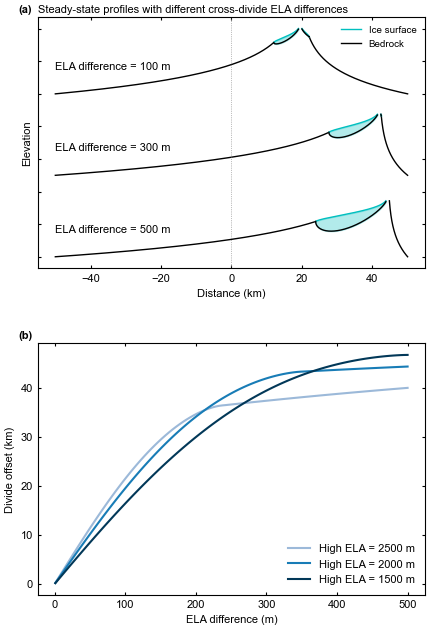

In [5]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(2, 1, figsize=(5, 7.5))
plt.subplots_adjust(hspace=0.3)

length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

ax = axarr[0]

gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta, plot=False)
initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

ela = 2000

length_threshold = 1e3
def find_valley_head_difference(x, ela_high, ela_low):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low

for i, ela_diff in enumerate([100, 300, 500]):
    sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela-ela_diff), method='brentq')
    migration_distance = sol.root

    gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, ELA=ela, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela-ela_diff, P=P, delta=delta, plot=False)

    #ax = axarr[i]
    
    vertical_offset = 2500*i

    for k, gp in enumerate([gp_high, gp_low]):
        if k == 0:
            x_sign = 1
        else:
            x_sign = -1
        ax.plot((gp.xf*x_sign+migration_distance)/1e3, gp.zf(gp.xf)-vertical_offset, '-', c='k', lw=1)
        if gp.xt > gp.xo:
            ax.fill_between((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg)-vertical_offset, gp.h(gp.xg)-vertical_offset, alpha=.3, color='c')
            ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.h(gp.xg)-vertical_offset, c='c', lw=1, label='Ice surface')
            ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg)-vertical_offset, c='k', lw=1, label='Bedrock')

        if i == 0 and k == 0:
            ax.legend(loc='upper right', fontsize=7)

    #ax.axvline(0, linestyle=':', color='0.5', linewidth=0.5)
    #ax.axvline(migration_distance/1e3, linestyle=':', color='0.5', linewidth=0.5)

    #ax.annotate('', xy=(migration_distance/1e3-0.5, 2000), xytext=(0.5, 2000), color='grey', horizontalalignment='right', verticalalignment='center',
    #            arrowprops=dict(color='grey', arrowstyle='simple'))

    #ax.text(migration_distance/1e3/2, 2200, 'Divide\nmigration', fontsize=8, color='0.5',
    #        horizontalalignment='center', verticalalignment='bottom')

    '''
    ax.hlines(ela, migration_distance/1e3, migration_distance/1e3+20, linestyle='--', color='0.5', linewidth=0.5)
    ax.hlines(ela - ela_diff, migration_distance/1e3-20, migration_distance/1e3, linestyle='--', color='0.5', linewidth=0.5)

    ax.text(migration_distance/1e3+20, ela+50, 'High ELA = {} m'.format(ela), fontsize=8, color='0.5',
            horizontalalignment='center', verticalalignment='bottom')
    ax.text(migration_distance/1e3-20, ela-ela_diff+50, 'Low ELA = {} m'.format(ela-ela_diff), fontsize=8, color='0.5',
            horizontalalignment='center', verticalalignment='bottom')
    '''
    #ax.set_xlabel('Distance (km)')
    #ax.set_ylabel('Elevation (m)')

    ax.text(-50, 1000-vertical_offset, 'ELA difference = {} m '.format(ela_diff), 
            horizontalalignment='left', verticalalignment='top',)

    

ax.axvline(0, linestyle=':', color='0.5', linewidth=0.5)

ax.tick_params(labelleft=False)

ax.text(-0.05, 1.01, '(a)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax.text(0, 1.01, 'Steady-state profiles with different cross-divide ELA differences',
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

#ax.text(-50, ela, 'High ELA is fixed at {} m '.format(ela), 
#            horizontalalignment='left', verticalalignment='top',)

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation')

##################################################
#ax = ax.inset_axes([0, -0.2, 1, 1])
ax = axarr[1]

cmap = matplotlib.cm.get_cmap('PuBu')
for k, ela in enumerate([2500, 2000, 1500]):
    migration_distance_list = np.array(migration_distance_dict['ela_{}'.format(ela)])
    ax.plot(ela_diff_list, migration_distance_list/1e3, color=cmap(0.4+k*0.3),
            label='High ELA = {} m'.format(ela))

ax.legend(loc='lower right')

ax.text(-0.05, 1.01, '(b)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

#ax.text(0.05, 1.02, 'Influence of ELA differences on divide migration distances', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax.set_xlabel('ELA difference (m)')
ax.set_ylabel('Divide offset (km)')

'''
ax = ax.twinx()

for ela in [1500, 2000, 2500]:
    timescale_list = np.array(timescale_dict['ela_{}'.format(ela)])
    ax.plot(ela_diff_list, timescale_list/1e6, '--', label='High ELA = {} m'.format(ela))

ax.set_ylabel('Timescale of divide migration  (Myr)')
'''
plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_migration_vs_ELA_diff.pdf'), dpi=600)

### Figure S2

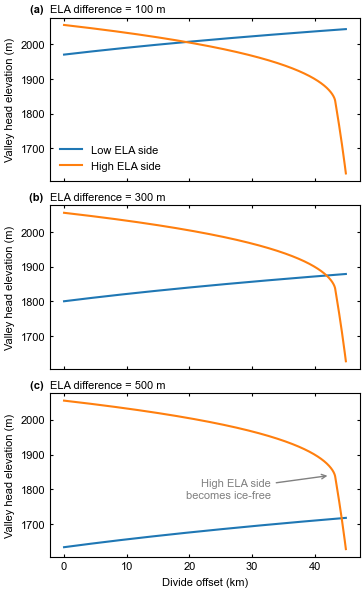

In [18]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(3, 1, figsize=(4, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15)

length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta, plot=False)
initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

#migration_distance_list = np.linspace(0, length - 1e3, 1001)
migration_distance_list = np.linspace(0, 45e3, 1001)

ela = 2000

for i, ela_diff in enumerate([100, 300, 500]):
    peak_high_list = []
    peak_low_list = []
    for migration_distance in migration_distance_list:

        gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, ELA=ela, P=P, delta=delta, plot=False)
        gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

        if gp_high.xt >= gp_high.xo:
            peak_high = gp_high.h(gp_high.xo)
        else:
            peak_high = gp_high.zf(gp_high.xo)
        
        if gp_low.xt >= gp_low.xo:
            peak_low = gp_low.h(gp_low.xo)
        else:
            peak_low = gp_low.zf(gp_low.xo)

        peak_high_list.append(peak_high)
        peak_low_list.append(peak_low)

    peak_high_list = np.array(peak_high_list)
    peak_low_list = np.array(peak_low_list)


    ax = axarr[i]

    ax.plot(migration_distance_list/1e3, peak_low_list, c='C0', label='Low ELA side')
    ax.plot(migration_distance_list/1e3, peak_high_list, c='C1', label='High ELA side')
    

    if i == 2:
        ax.set_xlabel('Divide offset (km)')
    ax.set_ylabel('Valley head elevation (m)')

    ax.text(-0.01, 1.02, '({}) '.format(chr(ord('a')+i)), fontweight='bold',
                horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
    ax.text(0.0, 1.02, 'ELA difference = {} m'.format(ela_diff),
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

axarr[0].legend(loc='lower left')

axarr[2].annotate('High ELA side\nbecomes ice-free', xy=(42.5, 1840), xytext=(33, 1800), color='grey', horizontalalignment='right', verticalalignment='center',
            arrowprops=dict(color='grey', arrowstyle='->'))

#ax.set_ylim([1000, 2200])

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_head_elev_change.pdf'), dpi=600)

### Figure S3

In [20]:
length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

length_threshold = 1e3

migration_distance_dict = {}
peak_elev_diff_dict = {}
timescale_dict = {}
migration_rate_dict = {}

ela_diff_list = np.linspace(1, 600, 100)

K_g = {'1': 1e-4, '2': 5e-6}
K_f = {'1': 1e-6, '2': 1e-9}
for ela_rel in [0.5, 0.6, 0.7]:
    for glacial_l in [1, 2]:
        for fluvial_n in [1, 2]:
            migration_distance_list = []
            peak_elev_diff_list = []
            timescale_list = []
            migration_rate_list = []
            for ela_diff in ela_diff_list:

                def find_valley_head_difference(x, ela_high, ela_low):
                    if length - x <= length_threshold:
                        return -1e9
                    if x < 0:
                        return 1e9
                    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta,
                                                    K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                                    ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)
                    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta,
                                                   K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                                   ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)

                    if gp_high.xt >= gp_high.xo:
                        peak_high = gp_high.h(gp_high.xo)
                    else:
                        peak_high = gp_high.zf(gp_high.xo)

                    if gp_low.xt >= gp_low.xo:
                        peak_low = gp_low.h(gp_low.xo)
                    else:
                        peak_low = gp_low.zf(gp_low.xo)

                    return peak_high - peak_low
                
                def find_valley_head_difference_for_rate(x, ela_high, ela_low):
                    if length - x <= length_threshold:
                        return -1e9
                    if x < 0:
                        return 1e9
                    gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela_high, P=P, delta=delta,
                                                    K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                                    ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)
                    gp_low = glacial_profile_model(U=uplift_rate*x, L=length, ELA=ela_low, P=P, delta=delta,
                                                   K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                                   ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)

                    if gp_high.xt >= gp_high.xo:
                        peak_high = gp_high.h(gp_high.xo)
                    else:
                        peak_high = gp_high.zf(gp_high.xo)
                    
                    if gp_low.xt >= gp_low.xo:
                        peak_low = gp_low.h(gp_low.xo)
                    else:
                        peak_low = gp_low.zf(gp_low.xo)

                    return peak_high - peak_low
                
                gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta,
                                                 K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                                 ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l,plot=False)
                initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

                ela = initial_peak_elev * ela_rel

                try:
                    sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff))
                    migration_distance = sol.root
                    gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)
                    #if gp_low.xt > length:
                    #    migration_distance = np.nan
                except ValueError:
                    migration_distance = np.nan

                migration_distance_list.append(migration_distance)
                peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
                '''
                if not np.isnan(migration_distance):
                    peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
                else:
                    peak_elev_diff_list.append(np.nan)
                '''

                sol = root_scalar(find_valley_head_difference_for_rate, bracket=[1, 10], args=(ela, ela - ela_diff), method='brentq')
                U_ratio = sol.root

                gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela, P=P, delta=delta, plot=False)
                gp_low = glacial_profile_model(U=uplift_rate*U_ratio, L=length, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

                S_g_high = (gp_high.h(gp_high.xo) + - gp_high.h(gp_high.xo+500))/500
                S_g_low = (gp_low.h(gp_low.xo) - gp_low.h(gp_low.xo+500))/500

                rate = (uplift_rate*(U_ratio-1)/(S_g_high+S_g_low))
                timescale_list.append(migration_distance/rate)
                migration_rate_list.append(rate)

            migration_distance_dict['l_{}_n_{}_ela_rel_{}'.format(glacial_l, fluvial_n, ela_rel)] = migration_distance_list
            peak_elev_diff_dict['l_{}_n_{}_ela_rel_{}'.format(glacial_l, fluvial_n, ela_rel)] = peak_elev_diff_list
            timescale_dict['l_{}_n_{}_ela_rel_{}'.format(glacial_l, fluvial_n, ela_rel)] = timescale_list
            migration_rate_dict['l_{}_n_{}_ela_rel_{}'.format(glacial_l, fluvial_n, ela_rel)] = migration_rate_list

#plt.plot(P_list, peak_elev_diff_list)

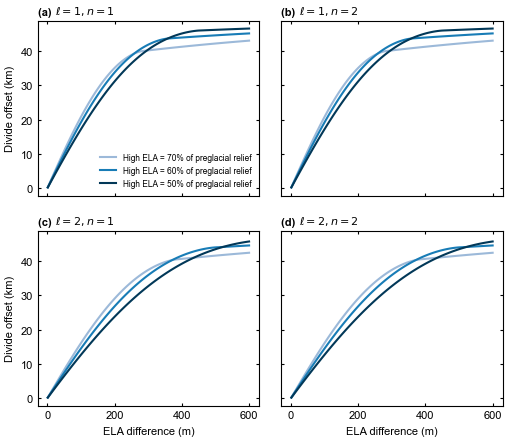

In [21]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(2, 2, figsize=(6, 5),  sharex=True, sharey=True,)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

axrow = 0
axcol = 0

cmap = matplotlib.cm.get_cmap('PuBu')
for glacial_l in [1, 2]:
    for fluvial_n in [1, 2]:
             
        ax = axarr[axrow, axcol]

        for k, ela_rel in enumerate([0.7, 0.6, 0.5]):
            y_value = np.array(migration_distance_dict['l_{}_n_{}_ela_rel_{}'.format(glacial_l, fluvial_n, ela_rel)])

            ax.plot(ela_diff_list, y_value/1e3, color=cmap(0.4+k*0.3),
                    label='High ELA = {:.0f}% of preglacial relief'.format(ela_rel*100))

        axcol += 1
        if axcol > 1:
            axcol = 0
            axrow += 1

        ax.text(0.0, 1.02, '({}) '.format(chr(ord('a')+axrow*2+axcol-1)), fontweight='bold',
                horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        ax.text(0.08, 1.02, r'$\ell={}, n={}$'.format(glacial_l, fluvial_n),
                horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

axarr[0, 0].legend(loc='lower right', fontsize=6)

for k in [0, 1]:
    axarr[1, k].set_xlabel('ELA difference (m)')
    axarr[k, 0].set_ylabel('Divide offset (km)')
#ax.set_xlabel('Uplift rate ({})'.format(r'$\mathrm{mm\/yr^{-1}}$'))
#ax.set_ylabel('Divide offset (km)')

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_migration_vs_erosion_params.pdf'), dpi=600)

## Figure 3

In [6]:
length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3
To = 2500
#P_ratio = 3


K_g = {'1': 1e-4, '2': 5e-6}
K_f = {'1': 1e-6, '2': 1e-9}
glacial_l = 1
fluvial_n = 2

length_threshold = 1e3

def find_valley_head_difference(x, P_ela_high, P_ela_low, To):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, To=To, P=P_ela_high, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, To=To, P=P_ela_low, delta=delta, plot=False)

    '''
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, To=To, P=P_ela_high, delta=delta,
                                    K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                    ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, To=To, P=P_ela_low, delta=delta,
                                    K=K_f[str(fluvial_n)], fluvial_slope_exp=fluvial_n,
                                    ce=K_g[str(glacial_l)], ice_sliding_exp=glacial_l, plot=False)
    '''
    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low


#P_ratio_list = np.linspace(1, 3, 110)
delta_P = np.linspace(1e-5, 1, 100)
P_ratio_list = (delta_P+P)/P

migration_distance_dict = {}

for ela in [1500, 2000, 2500, 100000]:
    To = ela + P/delta
    migration_distance_list = []
    for P_ratio in P_ratio_list:

        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P*P_ratio, 1e6), method='brentq')
        initial_migration_distance = sol.root

        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P*P_ratio, To), method='brentq')
        migration_distance = sol.root

        migration_distance_list.append(migration_distance)

    migration_distance_dict['ela_{}'.format(ela)] = migration_distance_list

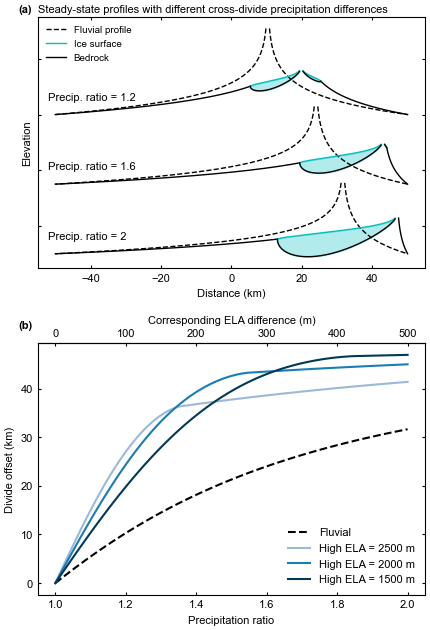

In [7]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(2, 1, figsize=(5, 7.5))
plt.subplots_adjust(hspace=0.3)

ax = axarr[0]

ela = 1500
P_ratio = 1.5
To = ela + P/delta

for i, P_ratio in enumerate([1.2, 1.6, 2]):

    vertical_offset = 2500*i

    sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P_ratio*P, 1e6), method='brentq')
    migration_distance = sol.root

    gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, To=1e6, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, To=1e6, P=P_ratio*P, delta=delta, plot=False)

    for k, gp in enumerate([gp_high, gp_low]):
        if k == 0:
            ax.plot((gp.xf+migration_distance)/1e3, gp.zf(gp.xf)-vertical_offset, '--', c='k', lw=1, label='Fluvial profile')
        else:
            ax.plot((-gp.xf+migration_distance)/1e3, gp.zf(gp.xf)-vertical_offset, '--', c='k', lw=1)

    sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P*P_ratio, To), method='brentq')
    migration_distance = sol.root

    gp_high = glacial_profile_model(U=uplift_rate, L=length-migration_distance, To=To, P=P, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, To=To, P=P_ratio*P, delta=delta, plot=False)

    for k, gp in enumerate([gp_high, gp_low]):
        if k == 0:
            x_sign = 1
        else:
            x_sign = -1
        ax.plot((gp.xf*x_sign+migration_distance)/1e3, gp.zf(gp.xf)-vertical_offset, '-', c='k', lw=1)
        if gp.xt > gp.xo:
            ax.fill_between((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg)-vertical_offset, gp.h(gp.xg)-vertical_offset, alpha=.3, color='c')
            ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.h(gp.xg)-vertical_offset, c='c', lw=1, label='Ice surface')
            ax.plot((gp.xg*x_sign+migration_distance)/1e3, gp.zg(gp.xg)-vertical_offset, c='k', lw=1, label='Bedrock')

        if i == 0 and k == 0:
            ax.legend(loc='upper left', fontsize=7)


    ax.text(-52, 800-vertical_offset, 'Precip. ratio = {}'.format(P_ratio), 
            horizontalalignment='left', verticalalignment='top',)

#ax.axvline(0, linestyle=':', color='0.5', linewidth=0.5)
#ax.axvline(migration_distance/1e3, linestyle=':', color='0.5', linewidth=0.5)

ax.tick_params(labelleft=False)

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation')

ax.text(-0.05, 1.01, '(a)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax.text(0, 1.01, 'Steady-state profiles with different cross-divide precipitation differences',
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

################################################################
ax = axarr[1]

initial_migration_distance_list = np.array(migration_distance_dict['ela_100000'])
ax.plot(P_ratio_list, initial_migration_distance_list/1e3, '--', color='k', label='Fluvial')

cmap = matplotlib.cm.get_cmap('PuBu')
for k, ela in enumerate([2500, 2000, 1500]):
    migration_distance_list = np.array(migration_distance_dict['ela_{}'.format(ela)])
    ax.plot(P_ratio_list, migration_distance_list/1e3, color=cmap(0.4+k*0.3),
            label='High ELA = {} m'.format(ela))

ax.legend(loc='lower right')

ax.set_ylabel('Divide offset (km)')
ax.set_xlabel('Precipitation ratio')

ax.tick_params(top=False)

secax = ax.secondary_xaxis(location='top', functions=(lambda x: (x*P-P)/delta, lambda x: (x*delta+P)/P))
secax.set_xlabel('Corresponding ELA difference (m)')

ax.text(-0.05, 1.05, '(b)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_migration_vs_P_ratio.pdf'), dpi=600)

## Figure 4

In [8]:
x_value_dict = {}
y_value_dict = {}

ela_diff_list = np.linspace(1, 500, 100)
ela_rel = 0.7

In [9]:
length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

length_threshold = 1e3

uplift_rate_list = [3e-4, 1e-3, 3e-3]
for uplift_rate in uplift_rate_list:
    migration_distance_list = []
    peak_elev_diff_list = []
    timescale_list = []
    migration_rate_list = []

    gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta,plot=False)
    initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

    ela = initial_peak_elev * ela_rel
    
    for ela_diff in ela_diff_list:

        def find_valley_head_difference(x, ela_high, ela_low):
            if length - x <= length_threshold:
                return -1e9
            if x < 0:
                return 1e9
            gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta, plot=False)

            if gp_high.xt >= gp_high.xo:
                peak_high = gp_high.h(gp_high.xo)
            else:
                peak_high = gp_high.zf(gp_high.xo)

            if gp_low.xt >= gp_low.xo:
                peak_low = gp_low.h(gp_low.xo)
            else:
                peak_low = gp_low.zf(gp_low.xo)

            return peak_high - peak_low
        
        def find_valley_head_difference_for_rate(x, ela_high, ela_low):
            if length - x <= length_threshold:
                return -1e9
            if x < 0:
                return 1e9
            gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela_high, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate*x, L=length, ELA=ela_low, P=P, delta=delta, plot=False)

            if gp_high.xt >= gp_high.xo:
                peak_high = gp_high.h(gp_high.xo)
            else:
                peak_high = gp_high.zf(gp_high.xo)
            
            if gp_low.xt >= gp_low.xo:
                peak_low = gp_low.h(gp_low.xo)
            else:
                peak_low = gp_low.zf(gp_low.xo)

            return peak_high - peak_low

        try:
            sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff))
            migration_distance = sol.root
            gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)
            if gp_low.xt > length:
                migration_distance = np.nan
        except ValueError:
            migration_distance = np.nan

        migration_distance_list.append(migration_distance)
        peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        '''
        if not np.isnan(migration_distance):
            peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        else:
            peak_elev_diff_list.append(np.nan)
        '''

        if not np.isnan(migration_distance):
            sol = root_scalar(find_valley_head_difference_for_rate, bracket=[1, 10], args=(ela, ela - ela_diff), method='brentq')
            U_ratio = sol.root

            gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate*U_ratio, L=length, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

            S_g_high = (gp_high.h(gp_high.xo) + - gp_high.h(gp_high.xo+500))/500
            S_g_low = (gp_low.h(gp_low.xo) - gp_low.h(gp_low.xo+500))/500

            rate = (uplift_rate*(U_ratio-1)/(S_g_high+S_g_low))
        else:
            rate = np.nan

        timescale_list.append(migration_distance/rate)
        migration_rate_list.append(rate)

    y_value_dict['U_{}_migration'.format(uplift_rate)] = migration_distance_list
    y_value_dict['U_{}_timescale'.format(uplift_rate)] = timescale_list
    y_value_dict['U_{}_rate'.format(uplift_rate)] = migration_rate_list

#plt.plot(P_list, peak_elev_diff_list)

In [10]:
length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3

length_threshold = 1e3

P_list = [0.3, 1, 3]
for P in P_list:
    migration_distance_list = []
    peak_elev_diff_list = []
    timescale_list = []
    migration_rate_list = []

    gp_dummy = glacial_profile_model(U=uplift_rate, L=length, ELA=1e6, P=P, delta=delta,plot=False)
    initial_peak_elev = gp_dummy.zf(gp_dummy.xo)

    ela = initial_peak_elev * ela_rel
    
    for ela_diff in ela_diff_list:

        def find_valley_head_difference(x, ela_high, ela_low):
            if length - x <= length_threshold:
                return -1e9
            if x < 0:
                return 1e9
            gp_high = glacial_profile_model(U=uplift_rate, L=length-x, ELA=ela_high, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate, L=length+x, ELA=ela_low, P=P, delta=delta, plot=False)

            if gp_high.xt >= gp_high.xo:
                peak_high = gp_high.h(gp_high.xo)
            else:
                peak_high = gp_high.zf(gp_high.xo)

            if gp_low.xt >= gp_low.xo:
                peak_low = gp_low.h(gp_low.xo)
            else:
                peak_low = gp_low.zf(gp_low.xo)

            return peak_high - peak_low
        
        def find_valley_head_difference_for_rate(x, ela_high, ela_low):
            if length - x <= length_threshold:
                return -1e9
            if x < 0:
                return 1e9
            gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela_high, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate*x, L=length, ELA=ela_low, P=P, delta=delta, plot=False)

            if gp_high.xt >= gp_high.xo:
                peak_high = gp_high.h(gp_high.xo)
            else:
                peak_high = gp_high.zf(gp_high.xo)
            
            if gp_low.xt >= gp_low.xo:
                peak_low = gp_low.h(gp_low.xo)
            else:
                peak_low = gp_low.zf(gp_low.xo)

            return peak_high - peak_low

        try:
            sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(ela, ela - ela_diff))
            migration_distance = sol.root
            gp_low = glacial_profile_model(U=uplift_rate, L=length+migration_distance, ELA=ela - ela_diff, P=P, delta=delta, plot=False)
            if gp_low.xt > length:
                migration_distance = np.nan
        except ValueError:
            migration_distance = np.nan

        migration_distance_list.append(migration_distance)
        peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        '''
        if not np.isnan(migration_distance):
            peak_elev_diff_list.append(find_valley_head_difference(0, ela, ela-ela_diff))
        else:
            peak_elev_diff_list.append(np.nan)
        '''

        if not np.isnan(migration_distance):
            sol = root_scalar(find_valley_head_difference_for_rate, bracket=[1, 10], args=(ela, ela - ela_diff), method='brentq')
            U_ratio = sol.root

            gp_high = glacial_profile_model(U=uplift_rate, L=length, ELA=ela, P=P, delta=delta, plot=False)
            gp_low = glacial_profile_model(U=uplift_rate*U_ratio, L=length, ELA=ela - ela_diff, P=P, delta=delta, plot=False)

            S_g_high = (gp_high.h(gp_high.xo) + - gp_high.h(gp_high.xo+500))/500
            S_g_low = (gp_low.h(gp_low.xo) - gp_low.h(gp_low.xo+500))/500

            rate = (uplift_rate*(U_ratio-1)/(S_g_high+S_g_low))
        else:
            rate = np.nan

        timescale_list.append(migration_distance/rate)
        migration_rate_list.append(rate)

    y_value_dict['P_{}_migration'.format(P)] = migration_distance_list
    y_value_dict['P_{}_timescale'.format(P)] = timescale_list
    y_value_dict['P_{}_rate'.format(P)] = migration_rate_list

#plt.plot(P_list, peak_elev_diff_list)

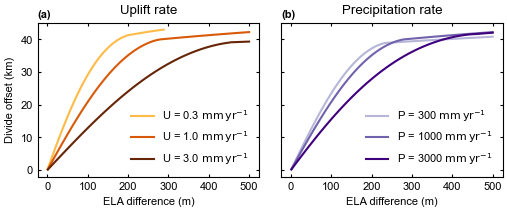

In [11]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(1, 2, figsize=(6, 2), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

ax = axarr[0]

cmap = matplotlib.cm.get_cmap('YlOrBr')
for k, uplift_rate in enumerate(uplift_rate_list):

    y_value = np.array(y_value_dict['U_{}_migration'.format(uplift_rate)])

    ax.plot(ela_diff_list, y_value/1e3, color=cmap(0.4+k*0.3),
            label='U = {:.1f} {}'.format(uplift_rate*1e3, r'$\mathrm{mm\/yr^{-1}}$'))

ax.text(0.0, 1.02, '(a)', fontweight='bold',
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax.legend(loc='lower right')

ax.set_title('Uplift rate')

#############################################
ax = axarr[1]
cmap = matplotlib.cm.get_cmap('Purples')
for k, P in enumerate(P_list):

    y_value = np.array(y_value_dict['P_{}_migration'.format(P)])

    ax.plot(ela_diff_list, y_value/1e3, color=cmap(0.4+k*0.3),
            label='P = {:.0f} {}'.format(P*1e3, r'$\mathrm{mm\/yr^{-1}}$'))

ax.text(0.0, 1.02, '(b)', fontweight='bold',
        horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

ax.legend(loc='lower right')

ax.set_title('Precipitation rate')


for k in [0, 1]:
    axarr[k].set_xlabel('ELA difference (m)')

axarr[0].set_ylabel('Divide offset (km)')
#axarr[1].set_ylabel('Timescale of divide migration (Myr)')

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_uplift_precip_offset_vs_ELA_diff.pdf'), dpi=600)

## Figure 5

In [12]:
# precipitation gradient

length = 50e3
uplift_rate = 1e-3
P = 1
delta = 2e-3
To = 2500
#P_ratio = 3

length_threshold = 1e3
def find_valley_head_difference_for_rate(x, initial_migration_distance, P_ela_high, P_ela_low, To):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    
    gp_high = glacial_profile_model(U=uplift_rate, L=length-initial_migration_distance, To=To, P=P_ela_high, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate*x, L=length+initial_migration_distance, To=To, P=P_ela_low, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low


def find_valley_head_difference(x, P_ela_high, P_ela_low, To):
    if length - x <= length_threshold:
        return -1e9
    if x < 0:
        return 1e9
    gp_high = glacial_profile_model(U=uplift_rate, L=length-x, To=To, P=P_ela_high, delta=delta, plot=False)
    gp_low = glacial_profile_model(U=uplift_rate, L=length+x, To=To, P=P_ela_low, delta=delta, plot=False)

    if gp_high.xt >= gp_high.xo:
        peak_high = gp_high.h(gp_high.xo)
    else:
        peak_high = gp_high.zf(gp_high.xo)
    
    if gp_low.xt >= gp_low.xo:
        peak_low = gp_low.h(gp_low.xo)
    else:
        peak_low = gp_low.zf(gp_low.xo)

    return peak_high - peak_low


P_ratio_list = np.linspace(1+1e-3, 2, 100)

timescale_dict = {}
migration_rate_dict = {}
for ela in [1500, 2000, 2500]:
    To = ela + P/delta
    timescale_list = []
    migration_rate_list = []
    for P_ratio in P_ratio_list:

        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P*P_ratio, 1e6), method='brentq')
        initial_migration_distance = sol.root

        sol = root_scalar(find_valley_head_difference_for_rate, bracket=[1, 5], args=(initial_migration_distance, P, P*P_ratio, To), method='brentq')
        U_ratio = sol.root
        #print(U_ratio)

        sol = root_scalar(find_valley_head_difference, bracket=[0, length-length_threshold], args=(P, P*P_ratio, To), method='brentq')
        migration_distance = sol.root

        gp_high = glacial_profile_model(U=uplift_rate, L=length-initial_migration_distance, To=To, P=P, delta=delta, plot=False)
        gp_low = glacial_profile_model(U=uplift_rate*U_ratio, L=length+initial_migration_distance, To=To, P=P*P_ratio, delta=delta, plot=False)

        try:
            S_g_high = (gp_high.h(gp_high.xo) - gp_high.h(gp_high.xo+500))/500
            if np.isnan(S_g_high):
                S_g_high = (gp_high.h(gp_high.xo) - gp_high.zf(gp_high.xo+500))/500
        except AttributeError:
            S_g_high = (gp_high.zf(gp_high.xo) - gp_high.zf(gp_high.xo+500))/500
        S_g_low = (gp_low.h(gp_low.xo) - gp_low.h(gp_low.xo+500))/500

        #S_g_high = (gp_high.h(gp_high.xo)+gp_high.xo*np.tan(gp_high.slope_threshold/180*np.pi)+ - gp_high.h(gp_high.xo+500))/1000
        #S_g_low = (gp_low.h(gp_low.xo)+gp_low.xo*np.tan(gp_low.slope_threshold/180*np.pi) - gp_low.h(gp_low.xo+500))/1000

        #S_g_high = np.tan(30/180*np.pi)
        #S_g_low= np.tan(30/180*np.pi)

        rate = (uplift_rate*(U_ratio-1)/(S_g_high+S_g_low))
        timescale_list.append((migration_distance-initial_migration_distance)/rate)
        migration_rate_list.append(rate)

    timescale_dict['P_grad_ela_{}'.format(ela)] = np.array(timescale_list)
    migration_rate_dict['P_grad_ela_{}'.format(ela)] = np.array(migration_rate_list)

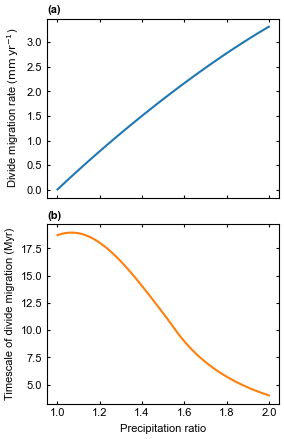

In [13]:
plt.close('all')
plt.style.use("myscience")
fig, axarr = plt.subplots(2, 1, figsize=(3, 5), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.05, hspace=0.15) 


ax = axarr[0]
for k, ela in enumerate([2000]):
    migration_rate_list = np.array(migration_rate_dict['P_grad_ela_{}'.format(ela)])
    ax.plot(P_ratio_list, migration_rate_list*1e3, color='C0',
            label='High ELA = {} m'.format(ela))

#ax.legend(loc='upper left')

#ax.set_xlabel('ELA difference (m)')
ax.set_ylabel('Divide migration rate ({})'.format(r'$\mathrm{mm\/yr^{-1}}$'))

ax.text(0.0, 1.02, '(a)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#ax.set_title('Initial asymmetric profile\ndue to precipitation gradient')

ax = axarr[1]
for k, ela in enumerate([2000]):
    timescale_list = np.array(timescale_dict['P_grad_ela_{}'.format(ela)])
    ax.plot(P_ratio_list, timescale_list/1e6, color='C1',
            label='High ELA = {} m'.format(ela))

#ax.set_yticks(np.linspace(5, 25, 5))
#ax.set_xlabel('ELA difference (m)')
ax.set_xlabel('Precipitation ratio')
ax.set_ylabel('Timescale of divide migration (Myr)')

ax.text(0.0, 1.02, '(b)', fontweight='bold', horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)

plt.savefig(os.path.join(savepath, 'test.pdf'), dpi=300)
#plt.savefig(os.path.join(savepath, 'Fig_rate_timescale.pdf'), dpi=600)